In [4]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, GlobalMaxPooling1D, \
Concatenate, BatchNormalization, Conv1D, ReLU, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import confusion_matrix
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.layers import Embedding, Flatten, Dense
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, pos_tag, ne_chunk
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import KFold

2024-01-18 23:47:08.693123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/rusab1/Work/learntorch/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load datasets and download NLTK lib init functions

In [8]:
test = pd.read_csv("datasets/test.txt", sep=";")
train = pd.read_csv("datasets/train.txt", sep=";")
val = pd.read_csv("datasets/val.txt", sep=";")

In [ ]:
keys = train['emotion'].unique()
sample_arr = []

In [ ]:
for k in keys:
    sample = train[train['emotion'] == k].sample(572)
    sample_arr.append(sample)

train = pd.concat(sample_arr)
train


In [ ]:
dir = f"{os.getcwd()}/nltk_datasets"
nltk.data.path.append(dir)
nltk.download("stopwords", download_dir=dir)
nltk.download("punkt", download_dir=dir)
nltk.download("maxent_ne_chunker", download_dir=dir)
nltk.download("words", download_dir=dir)
nltk.download("tagsets", download_dir=dir)
nltk.download("averaged_perceptron_tagger", download_dir=dir)

In [9]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower()
                     not in stop_words]
    return " ".join(filtered_text)


def stem_text(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)


def extract_entities(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    ne_chunks = ne_chunk(pos_tags)

    entities = []
    for chunk in ne_chunks:
        if hasattr(chunk, "label") and chunk.label():
            if chunk.label() == "NE":
                entities.append(" ".join([c[0] for c in chunk]))
    return entities


def create_tfidf_vectorizer(df):
    vectorizer = TfidfVectorizer(max_features=10000, use_idf=True)
    # Fit and transform the text data in the DataFrame column
    tfidf_matrix = vectorizer.fit_transform(df["sentence"])
    # Convert the TF-IDF matrix to a DataFrame for visualization
    return tfidf_matrix.toarray()


def tokenize_sentences(df):
    tr_text = df['sentence']
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(tr_text) 
                                
    sequences = tokenizer.texts_to_sequences(tr_text)
    return sequences


def encode_emotions(emotions):
    encoder = LabelEncoder()
    return encoder.fit_transform(emotions)

def pad_sequences_with_zeros(X, maxlen):
    return pad_sequences(X, maxlen=maxlen)

def check_frequency_of_words(df):
    # Combine all sentences into one string
    all_sentences = ' '.join(df['sentence'].tolist())

    # Tokenize the combined text into words
    words = all_sentences.split()

    # Create a Pandas Series to count word frequencies
    word_freq = pd.Series(words).value_counts()

    # Plot the top 20 most frequent words
    plt.figure(figsize=(10, 6))
    word_freq.head(20).plot(kind='bar', color='skyblue')
    plt.title('Top 20 Most Frequent Words in Sentences')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### pre-process textual data

In [12]:
train["sentence"] = train["sentence"].apply(remove_stopwords)
test["sentence"] = test["sentence"].apply(remove_stopwords)
val["sentence"] = val["sentence"].apply(remove_stopwords)

train["sentence"] = train["sentence"].apply(stem_text)
test["sentence"] = test["sentence"].apply(stem_text)
val["sentence"] = val["sentence"].apply(stem_text)

# train["entities"] = train["sentence"].apply(extract_entities)
# test["entities"] = test["sentence"].apply(extract_entities)
# val["entities"] = val["sentence"].apply(extract_entities)

train["sentence"] = train["sentence"].str.lower()
test["sentence"] = test["sentence"].str.lower()
val["sentence"] = val["sentence"].str.lower()

train_tfidf = tokenize_sentences(train)
test_tfidf = tokenize_sentences(test)
val_tfidf = tokenize_sentences(val)

train_padded = pad_sequences_with_zeros(train_tfidf, 50)
test_padded = pad_sequences_with_zeros(test_tfidf, 50)
val_padded = pad_sequences_with_zeros(val_tfidf, 50)

train['emotion_en'] = encode_emotions(train['emotion'])
test['emotion_en'] = encode_emotions(test['emotion'])
val['emotion_en'] = encode_emotions(val['emotion'])
# lets do lammentization next time

In [13]:
emotion_en_decrypted = train[['emotion','emotion_en']]
emotion_en_decrypted = emotion_en_decrypted.drop_duplicates()

### Save numpy dataset to reload back

In [ ]:
np.savez_compressed(f"{os.getcwd()}/datasets/preprocessed_data/nlp_training.npz", train=train_tfidf,test=test_tfidf,val=val_tfidf)

In [ ]:
main_arr_npz = np.load(f"{os.getcwd()}/datasets/preprocessed_data/nlp_training.npz")

In [ ]:
main_arr_npz['train'] 

In [14]:
y_train = to_categorical(train["emotion_en"])
y_test = to_categorical(test["emotion_en"])
y_val = to_categorical(val["emotion_en"])

## Train model

### our model

In [ ]:
model = Sequential([
    Embedding(10000, 64, input_length=50),
    LSTM(64,return_sequences=False),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adamax', loss='categorical_crossentropy',
              metrics=['accuracy'])

### siamese model

In [ ]:
input_shape_1 = (50,)  # Replace with your input shape
input_shape_2 = (50,)  # Replace with your input shape

# Define branches for each input
input_1 = Input(shape=input_shape_1)
input_2 = Input(shape=input_shape_2)

# Embedding layer for each input
embedding_1 = Embedding(10000, 64, input_length=50)(input_1)
embedding_2 = Embedding(10000, 64, input_length=50)(input_2)

# Flatten or any necessary layers for each branch
flatten_1 = Flatten()(embedding_1)
flatten_2 = Flatten()(embedding_2)

# Concatenate the branches
concatenated = Concatenate()([flatten_1, flatten_2])

# Dense layers and final output layer
dense_layer = Dense(64, activation='relu')(concatenated)
output_layer = Dense(6, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input_1, input_2], outputs=output_layer)

# Compile the model
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
input_shape_1 = (50,)  # Replace with your input shape
input_shape_2 = (50,)  # Replace with your input shape

# Define branches for each input
input_1 = Input(shape=input_shape_1)
input_2 = Input(shape=input_shape_2)

# Embedding layer for each input
embedding_1 = Embedding(10000, 64, input_length=50)(input_1)
embedding_2 = Embedding(10000, 64, input_length=50)(input_2)

# Flatten or any necessary layers for each branch
flatten_1 = Flatten()(embedding_1)
flatten_2 = Flatten()(embedding_2)

# lstm_1 = LSTM(64,return_sequences=True)(embedding_1)
# lstm_2 = LSTM(64,return_sequences=True)(embedding_2)

# Concatenate the branches
concatenated = Concatenate()([flatten_1, flatten_2])

# Dense layers and final output layer
dense_layer = Dense(64, activation='relu')(concatenated)
output_layer = Dense(6, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input_1, input_2], outputs=output_layer)

# Compile the model
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    [train_padded, train_padded], y_train, epochs=20, batch_size=128, validation_split=0.2
)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(train_padded)):
    print(f"Fold {fold + 1}")
    
    # Split the data into training and validation sets for this fold
    X_train_, X_val_ = train_padded[train_index], train_padded[val_index]
    y_train_, y_val_ = y_train[train_index], y_train[val_index]
    history = model.fit(
   [X_train_, X_train_], y_train_, epochs=5, batch_size=128, validation_data=([X_val_, X_val_], y_val_)
)


In [ ]:
model.save("models/nlp_training_model_self.h5")

### load old model

In [15]:
model = tf.keras.models.load_model("models/nlp_training_model_self.h5")
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_23 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_21 (Embedding)    (None, 50, 64)               640000    ['input_22[0][0]']            
                                                                                                  
 embedding_22 (Embedding)    (None, 50, 64)               640000    ['input_23[0][0]']            
                                                                                            

In [ ]:
model.evaluate([val_padded,val_padded], y_val)

In [ ]:
train.value_counts("emotion")

## Check model accuracy with custom inputs

In [21]:
input_sentence = ["i want to fight mohsin"]
df = test

df["sentence"] = df["sentence"].apply(remove_stopwords)
df["sentence"] = df["sentence"].apply(stem_text)

print(df["sentence"])

input_ = tokenize_sentences(df)
input_ = pad_sequences_with_zeros(input_, 50)

#pred_val = model_old.predict([input_,input_]).argmax()
#result = emotion_en_decrypted.loc[emotion_en_decrypted['emotion_en'] == pred_val, 'emotion'].values[0]
prediction = []

pred_val_model = model.predict([input_,input_])
for pred in pred_val_model:
    result_model = emotion_en_decrypted.loc[emotion_en_decrypted['emotion_en'] == pred.argmax(), 'emotion'].values[0]
    #"old:",pred_val,result,
    prediction.append(result_model)

0                   im feel rather rotten im ambiti right
1                               im updat blog feel shitti
2              never make separ ever want feel like asham
3       left bouquet red yellow tulip arm feel slightl...
4                                     feel littl vain one
                              ...                        
1995    keep feel like someon unkind wrong think get b...
1996              im feel littl cranki neg doctor appoint
1997                feel use peopl give great feel achiev
1998    im feel comfort derbi feel though start step s...
1999    feel weird meet w peopl text like dont talk fa...
Name: sentence, Length: 2000, dtype: object
63/63 [==============================] - 0s 2ms/step


In [26]:
tst = test["emotion"]


Shape of Confusion Matrix: (6, 6)


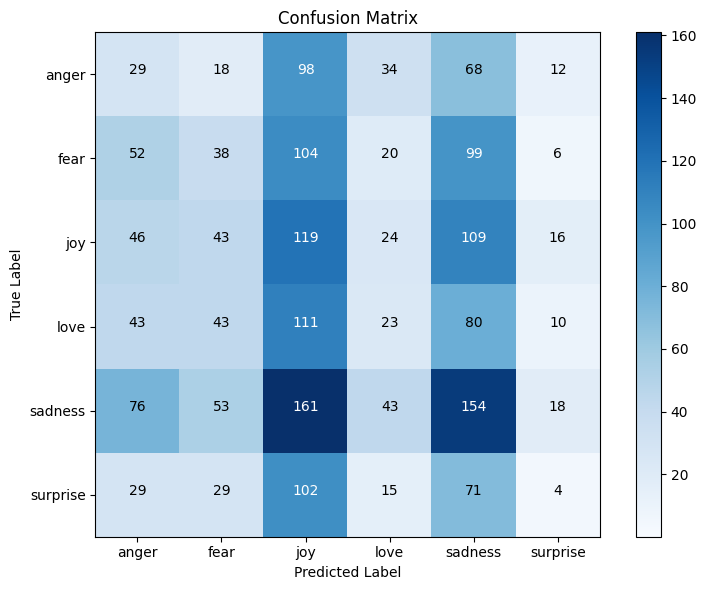

In [27]:
cm = confusion_matrix(prediction, tst)

# Identify misclassifications with counts greater than 1
misclassified_indices = np.where(cm > 0)

# Display the confusion matrix and its shape
# print("Confusion Matrix:")
# print(cm)
print("Shape of Confusion Matrix:", cm.shape)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))

# Define colors for the plot
cmap = plt.cm.Blues
# Set the color for misclassifications
#cmap.set_under('yellow')

plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.1)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding axis labels 
classes = np.unique(tst)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Adding annotations for misclassifications with counts > 1
thresh = cm.max() / 2.0
for i, j in zip(*misclassified_indices):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()